In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
import glob
import os
import PIL
import time

from IPython import display

In [3]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [4]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [5]:
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Metal device set to: Apple M1


2022-03-20 17:49:59.536525: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-20 17:49:59.536777: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [7]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Now, we transfer the weights of discriminator except the last layer to a new model, add a dense layer with 128 units, and add another dense layer with 10 units and softmax activation.

In [8]:
disc = checkpoint.discriminator

new_model = Sequential()
for i in range(len(disc.layers) - 1):
    new_model.add(disc.layers[i])

# freeze the layers 
for layer in new_model.layers:
    layer.trainable = False    

new_model.add(Dense(128))
new_model.add(Dense(10, activation='softmax'))
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [9]:
# view the initialized weights and bias of the second last dense layer; weights are uniformly randomly generated 
# and biases are all zeroes by default
new_model.layers[-2].weights

[<tf.Variable 'dense_2/kernel:0' shape=(6272, 128) dtype=float32, numpy=
 array([[-0.02152634,  0.00911626,  0.00304707, ..., -0.00722101,
          0.00094788,  0.00805156],
        [-0.00351078,  0.00406062,  0.01095512, ..., -0.01247145,
          0.01031647, -0.02840687],
        [-0.0023522 ,  0.00860476, -0.01179644, ..., -0.00035305,
          0.00462803,  0.01038867],
        ...,
        [ 0.02639199, -0.01829007,  0.00295215, ..., -0.01260072,
          0.02281583,  0.02793918],
        [-0.00117653,  0.00126085, -0.00232249, ..., -0.01255283,
          0.01652394, -0.01926172],
        [-0.01389979,  0.01829579, -0.01624038, ...,  0.02769553,
          0.00515006, -0.00361914]], dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(128,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [10]:
(train_img, train_lb), (test_img, test_lb) = tf.keras.datasets.mnist.load_data()

print(train_img.shape, train_lb.shape, test_img.shape, test_lb.shape, '\n')

# set random seed
np.random.seed(42)
trainsize = 10000  # number of training images we use, selected randomly
randtrain = np.random.choice(train_img.shape[0], trainsize, replace=False)
X_train, y_train = train_img[randtrain], train_lb[randtrain]

np.random.seed(10)
testsize = 10000  # number of testing images we use, selected randomly
randtest = np.random.choice(test_img.shape[0], testsize, replace=False)
X_test, y_test = test_img[randtest], test_lb[randtest]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,) 

(10000, 28, 28) (10000,) (10000, 28, 28) (10000,)


In [11]:
train_images = X_train.reshape((trainsize, 28, 28, 1))
train_images = (train_images.astype('float32') - 127.5) / 127.5

test_images = X_test.reshape((testsize, 28, 28, 1))
test_images = (test_images.astype('float32') - 127.5) / 127.5

train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

new_model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history1 = new_model.fit(train_images, train_labels, batch_size=100, epochs=7,
                        validation_data=(test_images, test_labels))

2022-03-20 17:51:38.710595: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-20 17:51:38.710791: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-20 17:51:38.803650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/7
 96/100 [===========================>..] - ETA: 0s - loss: 1.3243 - accuracy: 0.6454

2022-03-20 17:51:41.463171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 3s 14ms/step - loss: 1.3050 - accuracy: 0.6517 - val_loss: 0.7894 - val_accuracy: 0.8328
Epoch 2/7
100/100 [==============================] - 1s 12ms/step - loss: 0.7056 - accuracy: 0.8319 - val_loss: 0.5731 - val_accuracy: 0.8671
Epoch 3/7
100/100 [==============================] - 1s 13ms/step - loss: 0.5597 - accuracy: 0.8621 - val_loss: 0.4831 - val_accuracy: 0.8809
Epoch 4/7
100/100 [==============================] - 1s 14ms/step - loss: 0.4880 - accuracy: 0.8741 - val_loss: 0.4326 - val_accuracy: 0.8910
Epoch 5/7
100/100 [==============================] - 1s 13ms/step - loss: 0.4420 - accuracy: 0.8849 - val_loss: 0.3966 - val_accuracy: 0.8974
Epoch 6/7
100/100 [==============================] - 1s 14ms/step - loss: 0.4073 - accuracy: 0.8888 - val_loss: 0.3724 - val_accuracy: 0.9039
Epoch 7/7
100/100 [==============================] - 1s 14ms/step - loss: 0.3833 - accuracy: 0.8980 - val_loss: 0.3533 - val_accuracy: 0.9076


In [12]:
# unfreeze all layers 
for layer in new_model.layers:
    layer.trainable = True

# optimizer=new_model.optimizer
# optimizer.learning_rate=0.005
    
new_model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history2 = new_model.fit(train_images, train_labels, batch_size=100, epochs=8,
                        validation_data=(test_images, test_labels)) 

Epoch 1/8


2022-03-20 17:52:19.427026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 97/100 [============================>.] - ETA: 0s - loss: 0.3396 - accuracy: 0.9030

2022-03-20 17:52:21.865934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 3s 22ms/step - loss: 0.3418 - accuracy: 0.9023 - val_loss: 0.2978 - val_accuracy: 0.9128
Epoch 2/8
100/100 [==============================] - 2s 22ms/step - loss: 0.3015 - accuracy: 0.9107 - val_loss: 0.2690 - val_accuracy: 0.9234
Epoch 3/8
100/100 [==============================] - 2s 21ms/step - loss: 0.2778 - accuracy: 0.9197 - val_loss: 0.2534 - val_accuracy: 0.9279
Epoch 4/8
100/100 [==============================] - 2s 21ms/step - loss: 0.2564 - accuracy: 0.9270 - val_loss: 0.2393 - val_accuracy: 0.9345
Epoch 5/8
100/100 [==============================] - 2s 21ms/step - loss: 0.2430 - accuracy: 0.9306 - val_loss: 0.2244 - val_accuracy: 0.9380
Epoch 6/8
100/100 [==============================] - 2s 21ms/step - loss: 0.2241 - accuracy: 0.9360 - val_loss: 0.2154 - val_accuracy: 0.9404
Epoch 7/8
100/100 [==============================] - 2s 21ms/step - loss: 0.2080 - accuracy: 0.9385 - val_loss: 0.2065 - val_accuracy: 0.9397
Epoch 8/8
100/10

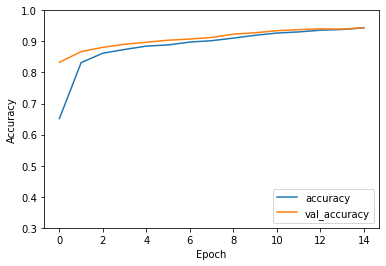

In [13]:
accuracy = history1.history['accuracy'] + history2.history['accuracy']
val_accuracy = history1.history['val_accuracy'] + history2.history['val_accuracy']

plt.figure()
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')
plt.show()

We can see that, using the tuned discriminator model, both training accuracy and testing are approximately 0.94 after 15 epochs.

actual label: 8


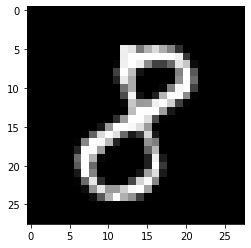

2022-03-20 17:53:08.510348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[4.9726215e-05 5.5645454e-05 7.1498086e-03 5.0617289e-02 3.3091558e-06
  1.5994636e-03 3.9842716e-06 1.9887175e-06 9.3859500e-01 1.9238422e-03]]
prediction: 8


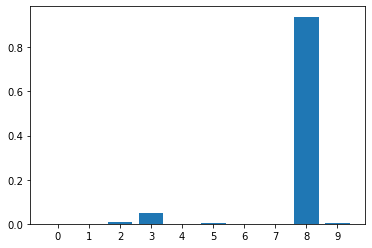

In [14]:
# demonstration: predict the ith test digit
i = np.random.randint(0, trainsize)

# show the actual ith digit
print('actual label:', np.argmax(test_labels[i]))
plt.figure()
plt.imshow(test_images[i,:,:,0], cmap='gray')
plt.show()

# predict
prediction = new_model.predict(test_images[i].reshape(1,28,28,1))

# get probability distribution and classification of the test digit
print(prediction)
print('prediction:', np.argmax(prediction))

# draw the barplot
plt.figure()
plt.bar(np.arange(0,10).astype('str'), prediction[0,:])
plt.show()

### Get Confusion Matrix

In [15]:
pred_labels = new_model.predict(test_images).argmax(axis=1)
true_labels = test_labels.argmax(axis=1)

In [16]:
confusion_mat = tf.math.confusion_matrix(labels=true_labels, predictions=pred_labels).numpy()
confusion_mat

array([[ 964,    0,    2,    1,    0,    4,    7,    1,    1,    0],
       [   0, 1116,    2,    2,    0,    0,    5,    2,    8,    0],
       [  13,    1,  956,   15,    9,    0,    7,   12,   14,    5],
       [   1,    0,   13,  958,    1,   13,    3,    6,   10,    5],
       [   1,    1,    3,    0,  927,    1,   10,    2,    5,   32],
       [   8,    2,    1,   18,    2,  826,   10,    2,   17,    6],
       [  17,    3,    1,    1,   13,    6,  914,    0,    3,    0],
       [   3,    5,   22,    8,    5,    1,    0,  944,    3,   37],
       [   6,    1,    5,   14,    6,    9,    5,    8,  908,   12],
       [  13,    5,    0,    9,   19,    6,    0,   12,   12,  933]],
      dtype=int32)

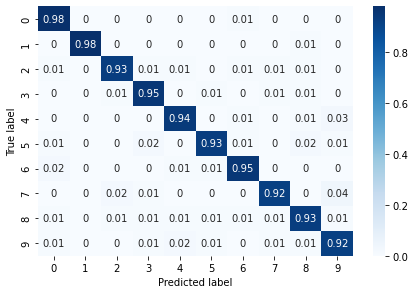

In [17]:
import pandas as pd
import seaborn as sns

confusion_mat_norm = np.around(confusion_mat.astype('float') / np.atleast_2d(confusion_mat.sum(axis=1)).T, decimals=2)

classes = np.arange(0,10).astype('str')
confusion_mat_df = pd.DataFrame(confusion_mat_norm,
                                index = classes, 
                                columns = classes)

figure = plt.figure()
sns.heatmap(confusion_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()